In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
from skimage.io import imsave
from machinedesign.autoencoder.interface import load
from machinedesign.viz import grid_of_images_default, horiz_merge
from lightjob.cli import load_db
import keras.backend as K
import matplotlib.pyplot as plt
from IPython.display import Image
from fluentopt.utils import flatten_dict
import seaborn as sns
from scipy.stats import binned_statistic
pd.options.display.max_columns = 100
sns.set_style('white')

def show_several(df, nb=100):
    for j in df.index:
        print(j)
        show_one(j, nb=nb)
def show_one(j, nb=100):
    try:
        X = np.load('../results/jobs/{}/gen/generated.npz'.format(j))['generated'][0:nb]
    except Exception:
        return
    X = grid_of_images_default(X, border=5, bordercolor=(0, 0, 0))
    imsave('out.png', X)
    im = Image('out.png')
    display(im)

Using Theano backend.


In [3]:
df_full = pd.read_csv('../../export/hypers.csv')
df_full = df_full.set_index('job_id')
#df_full['letters'] = 0.5 * df_full['letters_object'] + 0.5 * df_full['letters_diversity']

In [3]:
labels = [
    'emnist_digits_count',
    'emnist_letters_count',
    'digits_count', 
    'letters_count', 
    'digits_objectness', 
    'letters_objectness', 
    'digits_and_letters_objectness', 
    'emnist_objectness',
    'ratio_unique',
    'innovative',
    'existing',
    'noisy',
    'recons_ratio_hwrt',
    'recons_ratio_digits',
]
d = df_full[labels].corr()
def m(val):
    color = 'yellow' if abs(val) > 0.8 else 'red' if abs(val) < 0.2 else 'white'
    return 'background-color: %s' % color
d = d.style.applymap(m)
d

,emnist_digits_count,emnist_letters_count,digits_count,letters_count,digits_objectness,letters_objectness,digits_and_letters_objectness,emnist_objectness,ratio_unique,innovative,existing,noisy,recons_ratio_hwrt,recons_ratio_digits
emnist_digits_count,1,-0.23622,0.529626,-0.471411,0.402176,0.207992,-0.0201129,0.323599,0.208126,0.186157,0.362855,-0.488526,-0.100047,0.212078
emnist_letters_count,-0.23622,1,-0.255537,0.356421,0.415338,0.530674,0.69969,0.431676,0.685845,0.331575,-0.641894,0.148619,0.418786,0.341235
digits_count,0.529626,-0.255537,1,-0.909699,0.471748,0.352062,-0.0790447,0.430683,0.170926,0.461224,0.683339,-0.897975,0.161531,0.448496
letters_count,-0.471411,0.356421,-0.909699,1,-0.387914,-0.26775,0.159476,-0.350229,-0.0690646,-0.402,-0.815847,0.918353,-0.124274,-0.382607
digits_objectness,0.402176,0.415338,0.471748,-0.387914,1,0.910927,0.670086,0.949689,0.876528,0.815783,-0.156108,-0.655387,0.40715,0.673564
letters_objectness,0.207992,0.530674,0.352062,-0.26775,0.910927,1,0.812052,0.945681,0.845629,0.917492,-0.323285,-0.568581,0.57494,0.697328
digits_and_letters_objectness,-0.0201129,0.69969,-0.0790447,0.159476,0.670086,0.812052,1,0.708439,0.80338,0.577358,-0.612374,-0.0729931,0.355723,0.377163
emnist_objectness,0.323599,0.431676,0.430683,-0.350229,0.949689,0.945681,0.708439,1,0.83628,0.889177,-0.219553,-0.636159,0.47089,0.697506
ratio_unique,0.208126,0.685845,0.170926,-0.0690646,0.876528,0.845629,0.80338,0.83628,1,0.647173,-0.405657,-0.326489,0.40697,0.56688
innovative,0.186157,0.331575,0.461224,-0.402,0.815783,0.917492,0.577358,0.889177,0.647173,1,-0.174224,-0.701164,0.643904,0.726124


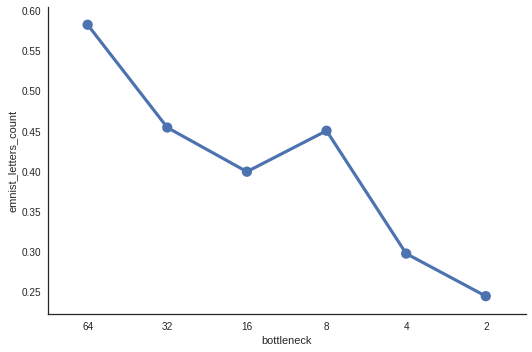

In [478]:
df = df_full
df = df[df['sampler'] == 'mnist_capacity']
df  = df[df['nb_layers']==3]
df = df.sort_values(by='bottleneck', ascending=False)
sns.factorplot(x='bottleneck', y='emnist_letters_count', data=df, order=[64, 32, 16, 8, 4, 2], size=5, aspect=1.5)
#show_several(df)
#col = 'bottleneck'
#fig, ax = plt.subplots(figsize=(10, 5))
#df.plot(col, 'letters_objectness', ax=ax, color='blue')
#df.plot(col, 'letters_count', ax=ax, color='green')
#df.plot(col, 'letters_diversity', ax=ax, color='red')

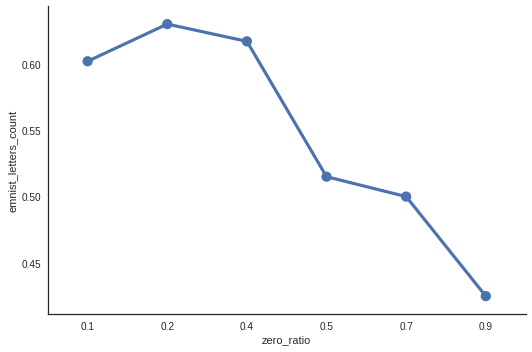

In [467]:
df = df_full
df = df[df['sampler'] == 'mnist_deep_kchannel']
df = df[df['nb_layers']==3]
#df = df[df['stride'] == 1]
#df = df[df['zero_ratio']!=0.4]
df = df.sort_values(by='zero_ratio')
col = 'zero_ratio'
#fig, ax = plt.subplots(figsize=(10, 5))
#df.plot(col, 'letters_object', ax=ax, color='blue')
#df.plot(col, 'letters_count', ax=ax, color='green')
#df.plot(col, 'letters_diversity', ax=ax, color='red')
sns.factorplot(x='zero_ratio', y='emnist_letters_count', data=df, size=5, aspect=1.5)
#show_several(df)

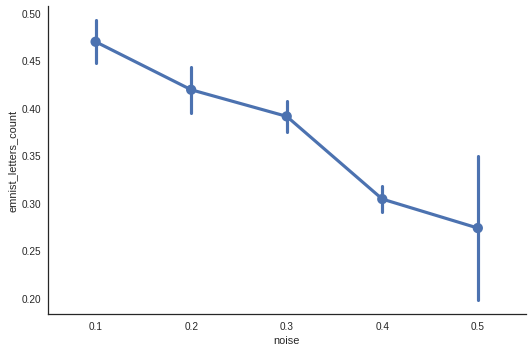

In [468]:
df = df_full
df = df[df['sampler'] == 'mnist_noise']
df = df[df['nb_layers']==3]
df = df[df['noise']<=0.5]
df = df.sort_values(by='noise')
sns.factorplot(x='noise', y='emnist_letters_count', data=df, size=5, aspect=1.5)
#col = 'noise'
#fig, ax = plt.subplots(figsize=(10, 5))
#df.plot(col, 'letters_object', ax=ax, color='blue')
#df.plot(col, 'letters_count', ax=ax, color='green')
#df.plot(col, 'letters_diversity', ax=ax, color='red')
#show_several(df)

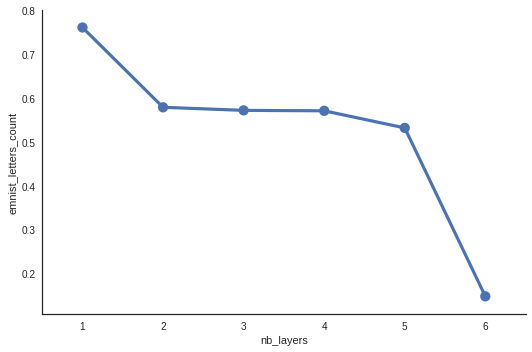

In [469]:
df = df_full
df = df[df['sampler'] == 'mnist_deep']
df = df[df['stride']==1]
df = df.sort_values(by='nb_layers')
sns.factorplot(x='nb_layers', y='emnist_letters_count', data=df, size=5, aspect=1.5)
#fig, ax = plt.subplots(figsize=(10, 5))
#df.plot('nb_layers', 'letters_object', ax=ax, color='blue')
#df.plot('nb_layers', 'letters_count', ax=ax, color='green')
#df.plot('nb_layers', 'letters_diversity', ax=ax, color='red')
#df.plot('nb_layers', 'letters_objectness', kind='scatter', ax=ax, s=50)

165


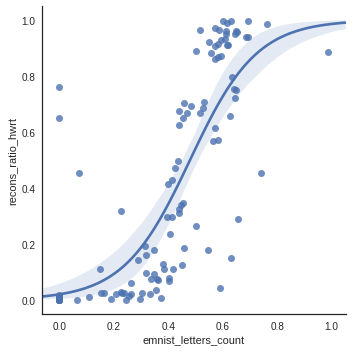

In [450]:
#df_full.plot('recons_ratio_hwrt', 'emnist_letters_count', kind='scatter')
df = df_full
#df = df[df['sampler'] == 'mnist_deep']
df = df[df['nb_layers']>=3]
sns.lmplot('emnist_letters_count', 'recons_ratio_hwrt', data=df, logistic=True)
print(len(df))

37237f9fff4f7b31450f75523b320087


/home/mcherti/miniconda/envs/py3/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


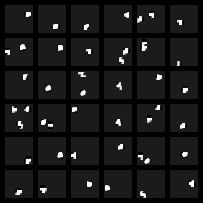

c9508eab5a4e53ba9e7908753321126b


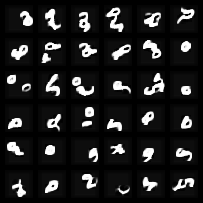

60168f92bfbc6331027b213e2e9d4f6f


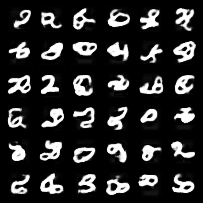

2f1da78673f5e27e2fc5aafcd9bb7baf


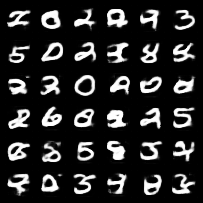

9a6da4b02514b0828331badb37217bb7


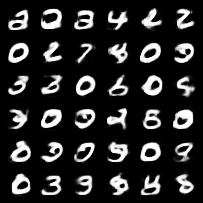

78d155d20b40759f2f5ac333aee1c616


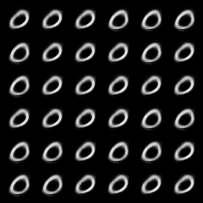

In [17]:
df = df_full
df = df[df['sampler'] == 'mnist_deep']
#df = df[df['nb_layers']==3]
df = df[df['stride']==4]
df = df.sort_values(by='nb_layers')
show_several(df, nb=36)

2edf8801a058ada680e1475b2c24cb4f


/home/mcherti/miniconda/envs/py3/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


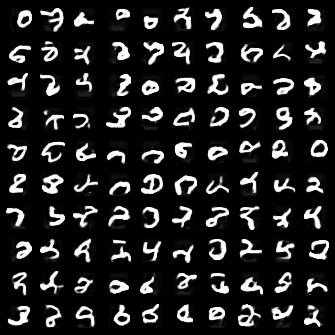

ab45d34bd45790c492f913e11f28b1dd


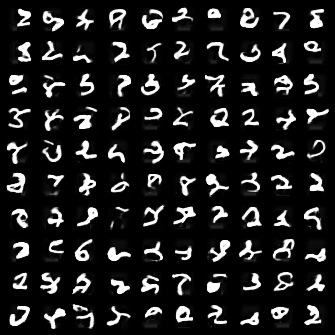

d8fd724967c9d8275c94886f01ac1ae2


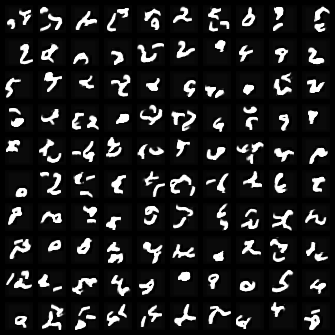

b2050358997fb2fa26a049823b1b2aa8


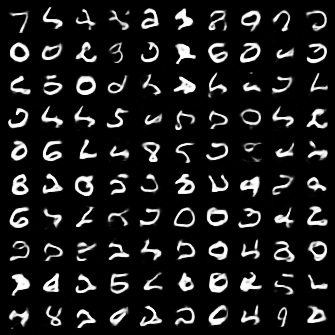

cd3d3b694a2fdf5938103feb39534e7d


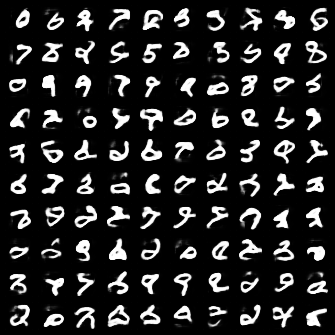

397df4acae0d1690daefd61015d898da


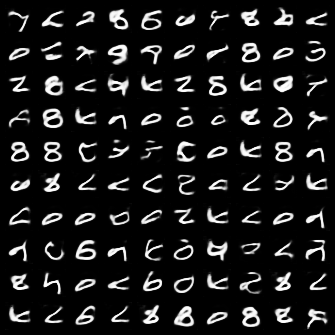

812d49b713606d441c290b32a8fd40a5


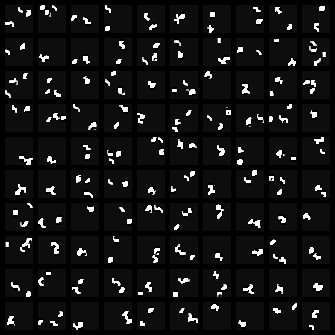

In [10]:
df = df_full
#df = df[df['sampler'] == 'mnist_deep_kchannel']
df = df[df['bottleneck']==16]
df = df.sort_values(by='innovative', ascending=False)
df = df.iloc[0:10]
show_several(df)